<div style="font-size:18pt;padding-top:20px; text-align:center">Домашнее задание 2. <b>Модели предсказания</b> </div><hr>
<div style="text-align:right;">Куценко А. А <span style="font-style: italic;font-weight: bold;">(ftruf357ft@gmail.com)</span></div>

Подключение стилей оформления

In [1]:
%%html
<link href="css/style.css" rel="stylesheet" type="text/css">

### Содержание

- [Вариант](#Вариант)
- [Задача 1. Реализация собственных классов и функций (4 балла)](#Задача-1.-Реализация-собственных-классов-и-функций-(4-балла))
- [Задача 2. Классификация и кросс-валидация (2 балла)](#Задача-2.-Классификация-и-кросс-валидация-(2-балла))
- [Задача 3. Классификация текстовых документов (4 балла)](#Задача-3.-Классификация-текстовых-документов-(4-балла))

# Цель работы
Приобрести опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.

При выполнении работы решаются следующие задачи:
- реализация собственных классов, совместимых с библиотекой `sklearn`;
- оценка влияния регуляризации в моделях предсказания;
- преобразование исходных данных посредством транформаторов `sklearn`;
- использование отложенной выборки и кросс-валидации;
- выбор гиперпараметров и интерпретация кривых обучения;
- оценка качества моделей предсказания;
- выявление преимуществ и недостатков методов предсказания в зависимости от поставленной задачи.

# Вариант

In [2]:
surname = "Куценко"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 55,  1, 44, 26, 18, 3, 38, 26, 18, 12,  3, 49, 45,
        7, 42, 9,  4,  3, 36, 33, 31, 29,  5, 4,  4, 19, 21, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 40 + 1

print("Задание № 2. Вариант: ", variant % 2 + 1)
print("Задание № 3. Вариант: ", variant % 3 + 1 )

Задание № 2. Вариант:  2
Задание № 3. Вариант:  3


## Задача 1. Реализация собственных классов и функций (4 балла)

### Условие

> **Замечание**. 1) Нельзя пользоваться готовыми реализациями `sklearn`; 2) чтобы избежать случая с вырожденной матрицей при оценке параметров добавьте незначительную регуляризацию по умолчанию или используйте `lstsq` из пакета `numpy` или др. способ; 3) используйте `random_state=0`

1. Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с `sklearn`. Передаваемые параметры: 1) коэффициент регуляризации (`alpha`). Использовать метод наименьших квадратов с регуляризацией;

2. Реализуйте класс для стандартизации признаков в виде трансформации, совместимый с `sklearn`. Передаваемые параметры: 1) `has_bias` (содержит ли матрица вектор единиц), 2) `apply_mean` (производить ли центровку)

3. Реализуйте функции для расчета $MSE$ и $R^2$ при отложенной выборке (`run_holdout`) и кросс-валидации (`run_cross_val`). Для кросс-валидации используйте **только** класс `KFold`. Выходными значениями должны быть $MSE$ и $R^2$ для обучающей и тестовой частей.

Шаблон кода:
```python
def run_holdout(model, X, y, train_size, random_state) -> dict:
    ...
    return scores


def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:
    ...
    return scores
```

4. Используя класс `Pipeline`, выполнить обучение линейной регрессии с предварительной стандартизацией с коэффициентом регуляризации равным `0` и `0.01`. Выведите значения параметров обученной модели. Выведите значения $MSE$ и $R^2$, полученные посредством функций `run_holdout` и `run_cross_val`. Отобразите график предсказание ($\hat{y}$) - действительное значение ($y$) для разных коэффициентов регуляризации для обучающего и текстового множества. Использовать следующие параметры:
    - `train_size=0.75`,
    - `n_splits=4`,
    - `shuffle=True`,
    - `random_state=0`
  
> **Замечание**: при формировании исходных данных использовался полином 16 степени одномерных данных.


### Выполнение

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

1. Нужно реализовать класс линейной регрессии с регуляризацией и использованием метода МНК. Поскольку реализуемый класс - это estimator, то нужно отнаследоваться от `BaseEstimator`, а также отнаследоваться от базового для всех регрессоров класса `RegressorMixin`

Поскольку в задании не указан тип, будем использовать L2 регуляризацию

In [4]:
class CustomRidge(BaseEstimator, RegressorMixin):
    epsilon = 1e-10
    
    def __init__(self, alpha=10e-4):
        self.alpha = alpha

        # Избегаем сингулярной матрицы, если коэффициент регуляризации близок или равен нулю
        if self.alpha < self.epsilon:
            self.alpha = self.epsilon

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_in_ = X.shape[1]

        X_ = np.c_[np.ones(X.shape[0]), X]
        
        E = np.eye(X_.shape[1])

        # не осуществляем регуляризацию для свободного параметра coef_[0]
        E[0, 0] = 0
        self.coef_ = np.linalg.inv(X_.T @ X_ + self.alpha * E) @ X_.T @ y
        return self

    def predict(self, X):
        check_is_fitted(self, 'coef_')
        X = check_array(X)
        X_ = np.c_[np.ones(X.shape[0]), X]
        return X_ @ self.coef_

#### Пояснение к формуле для коэффициентов

Модель линейной регрессии:
$$
h(x) = \theta^Tx = \theta_{0} + \theta_{1}x_{1} + \dots + \theta_{p}x_{p}
$$

Функция потерь для линейной регрессии с L2 регуляризацией:
$$
L(\theta) = \sum_{i=1}^n \big( y_{i}-h(x_{i}) \big)^2 + \alpha \sum_{j=1}^p \theta_{j}^2 = \sum_{i=1}^n \Big[ y_{i} - \big( \theta_{0} + \theta_{1}x_{i_{1}} + \dots + \theta_{p}x_{i_p} \big) \Big]^2 + \alpha \sum_{j=1}^p \theta_{j}^2
$$

Постановка задачи заключается в минимизации функции потерь:
$$
\hat{\theta} = \underset{\theta}{\operatorname{argmin}} L(\theta)
$$

В методе МНК минимум функции $L(\theta)$ осуществляется поиском экстремума функции, то есть к приравниванию частных производных к нулю и решению СЛАУ.

Частная производная $L(\theta)$ по координате $\theta_{j}$:
$$
\begin{gather*}
\dfrac{\partial L(\theta)}{\partial \theta_{j}} = \dfrac{\partial}{\partial \theta_{j}} \left[ \sum_{i=1}^n \big( y_{i} - h(x_{i}) \big)^2 + \alpha \sum_{k=1}^p \theta_{k}^2 \right] = \\
= \dfrac{\partial}{\partial \theta_{j}} \sum_{i=1}^n \Big[ y_{i} - \big( \theta_{0} + \theta_{1}x_{i1} + \theta_{2}x_{i2} + \dots + \theta_{p}x_{ip} \big) \Big]^2 + \alpha \dfrac{\partial}{\partial\theta_{j}} \left(\theta_{0}^2 + \theta_{1}^2 + \dots + \theta_{j}^2 + \dots \theta_{k}^2\right) = \\
= \sum_{i=1}^n -2x_{ij} \big[ y_{i} - (\theta_{0} + \theta_{1}x_{i_{1}} + \theta_{2}x_{i2} + \dots + \theta_{p}x_{ip}) \big] + 2\alpha\theta _{j}
\end{gather*}
$$

В матричной форме получим:
$$
\nabla L(\theta) = -2X^T(y-X\theta) + 2\alpha\theta
$$

Приравниваем к нулю:
$$
\begin{align}
-2X^T(y-X\theta) &= -2\alpha\theta \\
X^T(y-X\theta) &= \alpha \theta \\
X^T X \theta + \alpha\theta &= X^T y \\
X^TX\theta + \alpha E \theta &= X^T y \\
(X^T X + \alpha E) \theta &= X^T y \\
\theta &= (X^T X + \alpha E)^{-1} X^T y\ ,
\end{align}
$$
где $E$ - единичная матрица, $\alpha \geqslant 0$

Проверка на совместимость с `sklearn`

In [5]:
%pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import is_regressor

In [7]:
check_estimator(estimator=CustomRidge())

In [8]:
# Note: Based on _estimator_type
is_regressor(CustomRidge())

True

Реализуем `train_test_split` функционально аналогичный варианту из `sklearn`

In [9]:
from decimal import Decimal, getcontext
import math

def check_array_lengths(*arrays):
    if not arrays:
        return -1
    
    first_length = len(arrays[0])
    for i, arr in enumerate(arrays):
        if len(arr) != first_length:
            raise ValueError(f"Массив {i} имеет длину {len(arr)}, ожидалось получить массив длины {first_length}")

    return first_length

def get_train_test_separation_boundaries(test_size=None, train_size=None):
    # переданы оба значения
    if None not in (train_size, test_size):
        test_size = Decimal(test_size)
        train_size = Decimal(train_size)

        if train_size + test_size != 1:
            raise ValueError(f"Ошибка: train_size + test_size = {train_size + test_size}. Ожидалось 1.0")
    else:
        # не передано ни одно значение
        if train_size is None and test_size is None:
            train_size = 0.25
            test_size = Decimal(1) - Decimal(train_size)
        else:
            # передано какое-то из двух значений
            if train_size is not None:
                train_size = Decimal(train_size)
                test_size = 1 - train_size
            
            if test_size is not None:
                test_size = Decimal(test_size)
                train_size = 1 - test_size
    
    return (float(train_size), float(test_size))
        

def custom_train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True):
    # Проверяем, что все массивы одинаковой длины
    arr_length = check_array_lengths(*arrays)

    train_portion, test_portion = get_train_test_separation_boundaries(test_size, train_size)

    train_elems_count = math.trunc(train_portion * arr_length)
    if train_elems_count == 0:
        raise ValueError(f"Ошибка: количество элементов для train равно 0")
    elif train_elems_count == arr_length:
        raise ValueError(f"Ошибка: количество элементов для test равно 0")

    result = []
    
    indexes = np.array([i for i in range(0, arr_length)])
    
    if shuffle:
        rng = np.random.default_rng(seed=random_state)
        rng.shuffle(indexes)
        
    for array in arrays:
        if array.ndim == 1:
            result.append(array[indexes[:train_elems_count]])
            result.append(array[indexes[train_elems_count:]])

        if array.ndim == 2:
            result.append(array[indexes[:train_elems_count], :])
            result.append(array[indexes[train_elems_count:], :])

    return result

Проверим поведение `CustomRidge` с эталонной реализацией `Ridge` из `sklearn`

In [10]:
TEST_REGULARIZATION = 0.1

In [11]:
from scipy import stats
from sklearn.linear_model import Ridge

def regression_dataset(n=100):
    """Генерация исходных данных"""
    x = stats.uniform.rvs(size=n, loc=0, scale=6, random_state=0)
    f = lambda x: 0.3 + 2*x
    y = stats.norm.rvs(size=n, loc=0, scale=0.3, random_state=0) + f(x)
    return (x, y, f)

# Инициализация исходных данных
x, y, f = regression_dataset()

# Представление признака x в матричной форме
X_ = x.reshape(-1, 1)

# Формирование обучающего и тестового подмножеств
X_train, X_test, y_train, y_test = custom_train_test_split(X_, y, test_size=0.3, random_state=200)

ridge = Ridge(alpha=TEST_REGULARIZATION, fit_intercept=True)
ridge.fit(X_train, y_train)

# Параметры обученной модели
print("Параметры для Ridge модели:")
print("\tw{} = {}".format(0, ridge.intercept_))
for indx, coef in enumerate(ridge.coef_):
    print("\tw{} = {}".format(indx+1, coef))
print(f"Test score = {ridge.score(X_test, y_test)}")

custom_ridge = CustomRidge(alpha=TEST_REGULARIZATION)
custom_ridge.fit(X_train, y_train)

# Параметры обученной модели
print("\nПараметры для CustomRidge модели:")
for indx, coef in enumerate(custom_ridge.coef_):
    print("\tw{} = {}".format(indx+1, coef))
print(f"Test score = {custom_ridge.score(X_test, y_test)}")

Параметры для Ridge модели:
	w0 = 0.32747575219383496
	w1 = 1.9894625695363992
Test score = 0.9946556230177561

Параметры для CustomRidge модели:
	w1 = 0.32747575219382574
	w2 = 1.9894625695364014
Test score = 0.994655623017756


Как видим, обе реализации выдали приблизительно одинаковые параметры

2. Нужно реализовать класс-трансформер, совместимый с `sklearn`. Для этого нужно отнаследоваться от классов `BaseEstimator`, `TransformerMixin`

$$
x_{s} = \dfrac{x - \overline{x}}{s}
$$

In [12]:
class CustomStandardScaller(BaseEstimator, TransformerMixin):

    def __init__(self, has_bias=False, apply_mean=True):
        self.has_bias = has_bias
        self.apply_mean = apply_mean

    def fit(self, X, y=None):
        X = check_array(X) # или другой check
        self.n_features_in_ = X.shape[1]
        self.mean_ = np.mean(X, axis=0, dtype=float)
        self.var_ = np.var(X, axis=0, dtype=float)
        return self

    def transform(self, X):
        check_is_fitted(self, ['mean_', 'var_'])
        X = check_array(X)
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"Dimension mismatch. Expected {self.n_features_in_} features, got {X.shape[1]}")
        
        # Избегаем деления на ноль
        vars = np.copy(self.var_)
        vars[vars == 0] = 1

        if self.has_bias:
            ones_column = X[:, 0].reshape(-1, 1)
            other_columns = X[:, 1:]
            result = (other_columns - int(self.apply_mean) * self.mean_[1:]) / np.sqrt(vars[1:])
            return np.hstack([ones_column, result])
        
        return (X - int(self.apply_mean) * self.mean_) / np.sqrt(vars)

Проверка на совместимость с `sklearn`

In [13]:
check_estimator(CustomStandardScaller())

Сравним поведение с `StandardScaller` из `sklearn`

In [14]:
from sklearn.preprocessing import StandardScaler

N = 100
n = N // 20

x, y, f = regression_dataset(N)

# Сделаем больше столбцов
x_for_scaler = x.reshape(-1, n)

scaler = StandardScaler()
scaler_data = scaler.fit_transform(x_for_scaler)
print(f"Матожидания: {scaler.mean_}")
print(f"Отклонения: {scaler.var_}")

print(scaler_data[:5])

custom_scaler = CustomStandardScaller(has_bias=False, apply_mean=True)
custom_scaler_data = custom_scaler.fit_transform(x_for_scaler)
print(f"\nМатожидания: {custom_scaler.mean_}")
print(f"Отклонения: {custom_scaler.var_}")

print(custom_scaler_data[:5])

print('\nРазность между трансформерами:')
scaler_data - custom_scaler_data

Матожидания: [2.68932584 2.89323492 2.88091148 3.49850031 2.22184263]
Отклонения: [2.71149376 1.87346466 4.03454043 2.70120176 2.79760696]
[[ 0.36653266  1.02130098  0.36625646 -0.13945638  0.19136986]
 [ 0.7202688  -0.19558905  1.22956596  1.38937023  0.04711602]
 [ 1.25163824  0.20466519  0.26254682  1.25040333 -1.07355081]
 [-1.31572286 -2.02515678  1.05286776  0.71214875  1.79255146]
 [ 1.93262817  1.3893863  -0.05577735  0.7208097  -0.90409644]]

Матожидания: [2.68932584 2.89323492 2.88091148 3.49850031 2.22184263]
Отклонения: [2.71149376 1.87346466 4.03454043 2.70120176 2.79760696]
[[ 0.36653266  1.02130098  0.36625646 -0.13945638  0.19136986]
 [ 0.7202688  -0.19558905  1.22956596  1.38937023  0.04711602]
 [ 1.25163824  0.20466519  0.26254682  1.25040333 -1.07355081]
 [-1.31572286 -2.02515678  1.05286776  0.71214875  1.79255146]
 [ 1.93262817  1.3893863  -0.05577735  0.7208097  -0.90409644]]

Разность между трансформерами:


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Как видим, результаты обоих трансформеров совпали

3. Реализуем функции для подсчета $MSE$ и $R^2$ на обучающей и тестовой выборке для варианта с отложенной выборкой (`holdout`) и с кросс-валидацией `KFold`

In [15]:
from sklearn.model_selection import KFold
from sklearn.base import clone

In [16]:
TEST  = 'TEST'
TRAIN = 'TRAIN'

In [17]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_r2(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def run_holdout(model, X, y, train_size, random_state=None):
    X_train, X_test, y_train, y_test = custom_train_test_split(X, y, train_size=train_size, random_state=random_state)

    # Используем функцию только для оценки качества модели, но не для обучения переданной через параметры модели model
    model = clone(model)
    model.fit(X_train, y_train)
    
    return {
        TEST: {
            'MSE': calculate_mse(y_test, model.predict(X_test)),
            'R2': calculate_r2(y_test, model.predict(X_test))
        },
        TRAIN: {
            'MSE': calculate_mse(y_train, model.predict(X_train)),
            'R2' : calculate_r2(y_train, model.predict(X_train))
        }
    }

def run_cross_val(model, X, y, n_splits, shuffle, random_state):
    mses = {
        TEST: np.full(n_splits, np.inf),
        TRAIN: np.full(n_splits, np.inf)
    }
    r2s = {
        TEST: np.full(n_splits, np.inf),
        TRAIN: np.full(n_splits, np.inf)
    }

    model = clone(model)
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    for i, (train_indexes, test_indexes) in enumerate(kf.split(X)):
        model.fit(X[train_indexes], y[train_indexes])

        mses[TEST][i] = calculate_mse(y[test_indexes], model.predict(X[test_indexes]))
        mses[TRAIN][i] = calculate_mse(y[train_indexes], model.predict(X[train_indexes]))

        r2s[TEST][i] = calculate_r2(y[test_indexes], model.predict(X[test_indexes]))
        r2s[TRAIN][i] = calculate_r2(y[train_indexes], model.predict(X[train_indexes]))

    return {
        TEST: {
            'MSE': np.mean(mses[TEST]),
            'R2': np.mean(r2s[TEST])
        },
        TRAIN: {
            'MSE': np.mean(mses[TRAIN]),
            'R2': np.mean(r2s[TRAIN])
        }
    }

4. Используя класс `Pipeline`, проведем оценку параметров линейной регрессии с регуляризацией и предварительной стандартизацией

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
ALPHAS       = [0, 0.01]
TRAIN_SIZE   = 0.75
SPLITS       = 4
SHUFFLE      = True
RANDOM_STATE = 0

Проверяем наличие датасета локально, если его нет, то скачиваем

In [20]:
%%bash
cat << 'EOF' > /tmp/download_dataset_file.sh

download_dataset_file() {
    # Messages from utils in stderr are not an errros
    exec 2>&1

    local dataset_path="$1"
    local filename="$2"
    local link="$3"

    echo "Let's check the availability of the dataset locally"

    if [ ! -f ${dataset_path}/${filename} ]; then
        mkdir -p ${dataset_path}
        pushd ${dataset_path}

        echo "Dataset file is missing. Downloading..."

        curl --progress-bar -Ls "${link}" -o ${filename}
        popd
    else
        echo "Dataset file exist. I'm skipping the download"
    fi
}
EOF

In [21]:
%%bash

source /tmp/download_dataset_file.sh

dataset_path="../data/A2_PM_dataset"
regularization_file="regularization.csv"
link="https://raw.githubusercontent.com/MLMethods/Assignments/refs/heads/master/data/A2_Model_Selection/regularization.csv"

download_dataset_file "${dataset_path}" "${regularization_file}" "${link}"

Let's check the availability of the dataset locally
Dataset file exist. I'm skipping the download


In [22]:
FILE_PATH = "../data/A2_PM_dataset/regularization.csv"

In [23]:
df = pd.read_csv(FILE_PATH, sep=",")
df.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,Y
0,3.856603,14.873388,57.360757,221.217682,853.148822,3290.256492,1.268921e+04,4.893726e+04,1.887316e+05,7.278629e+05,2.807078e+06,1.082579e+07,4.175077e+07,1.610161e+08,6.209754e+08,2.394856e+09,9.209759
1,0.103760,0.010766,0.001117,0.000116,0.000012,0.000001,1.294799e-07,1.343480e-08,1.393992e-09,1.446402e-10,1.500783e-11,1.557209e-12,1.615756e-13,1.676504e-14,1.739537e-15,1.804939e-16,10.409240
2,3.168241,10.037752,31.802020,100.756468,319.220791,1011.368453,3.204259e+03,1.015187e+04,3.216356e+04,1.019019e+05,3.228498e+05,1.022866e+06,3.240687e+06,1.026728e+07,3.252921e+07,1.030604e+08,7.643742
3,3.744019,14.017681,52.482471,196.495391,735.682558,2754.409777,1.031256e+04,3.861044e+04,1.445582e+05,5.412288e+05,2.026371e+06,7.586773e+06,2.840503e+07,1.063490e+08,3.981726e+08,1.490766e+09,8.453341
4,2.492535,6.212731,15.485450,38.598027,96.206935,239.799159,5.977078e+02,1.489808e+03,3.713398e+03,9.255774e+03,2.307034e+04,5.750364e+04,1.433298e+05,3.572546e+05,8.904697e+05,2.219527e+06,9.317824


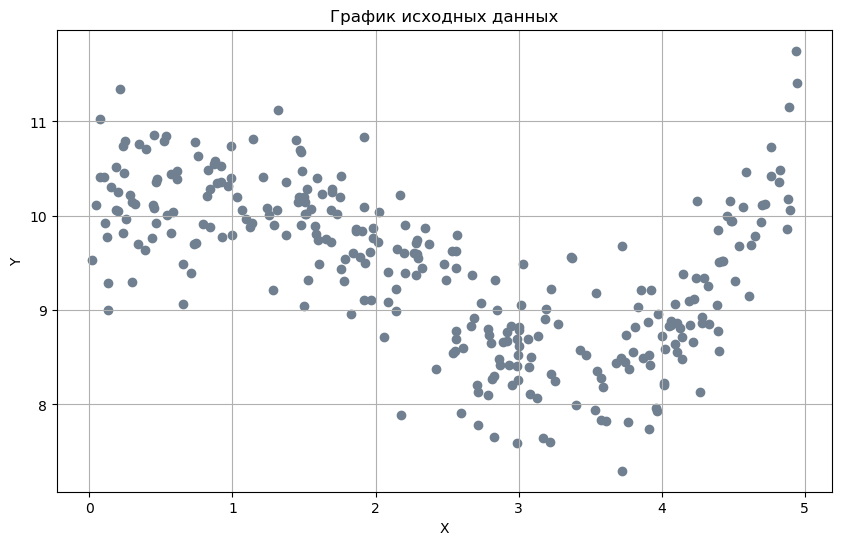

In [24]:
X = df.loc[:, df.columns != 'Y'].to_numpy()
y = df['Y'].to_numpy()

plt.figure("1", figsize=[10, 6])

plt.subplot(1,1,1)
plt.title("График исходных данных")
plt.scatter(X[:, 0], y, color="slategrey")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

plt.show()

In [25]:
scores = {}
pipelines = {}

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

for alpha in ALPHAS:
    scores[alpha] = {}

    pipelines[alpha] = Pipeline([
        ("standardizer", CustomStandardScaller(has_bias=False, apply_mean=True)),
        ("linear_model", CustomRidge(alpha=alpha))
    ])

    pipe = pipelines[alpha]
    pipe.fit(X_train, y_train)

    print("Коэффициент регуляризации:\n\ta =", alpha)
    print("Параметры модели:")
    for indx, coef in enumerate(pipe.named_steps["linear_model"].coef_):
        print(f"\tw{indx} = {coef}")

    scores[alpha]['HOLDOUT'] = run_holdout(pipe, X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
    scores[alpha]['CROSSVAL'] = run_cross_val(pipe, X, y, n_splits=SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

    for validation_type in ['HOLDOUT', 'CROSSVAL']:
        print("\nМетрики при ", end='')
        if validation_type == 'HOLDOUT':
            print("отложенной выборке (holdout)")
        else:
            print("кросс-валидации KFold")

        for set_type in [TRAIN, TEST]:
            print(f"\t{set_type} MSE = {scores[alpha][validation_type][set_type]['MSE']}")
            print(f"\t{set_type} R2 = {scores[alpha][validation_type][set_type]['R2']}")

    if alpha != ALPHAS[-1]:
        print('\n\n')

Коэффициент регуляризации:
	a = 0
Параметры модели:
	w0 = 9.444296175528054
	w1 = 3.7874687525570443
	w2 = -73.74723349273854
	w3 = 652.5943016575236
	w4 = -3056.170226549623
	w5 = 7896.792834387104
	w6 = -10455.907589668692
	w7 = 3403.4949918964144
	w8 = 6667.880609684114
	w9 = -3202.469066546199
	w10 = -5912.272478082326
	w11 = 1072.407052858083
	w12 = 5304.08066172826
	w13 = 589.8287865939227
	w14 = -4312.196516992471
	w15 = 1045.7877940277137
	w16 = 375.9338520260145

Метрики при отложенной выборке (holdout)
	TRAIN MSE = 0.21628402809930625
	TRAIN R2 = 0.7061940056277007
	TEST MSE = 0.24089228695805867
	TEST R2 = 0.6456458975871935

Метрики при кросс-валидации KFold
	TRAIN MSE = 0.21628085397121016
	TRAIN R2 = 0.7002818145862557
	TEST MSE = 0.24059181909404576
	TEST R2 = 0.6647199278843495



Коэффициент регуляризации:
	a = 0.01
Параметры модели:
	w0 = 9.444296175528624
	w1 = 0.9829399475603691
	w2 = -2.961744941711617
	w3 = -1.5220130846219302
	w4 = 0.9567178177495431
	w5 = 1.8283

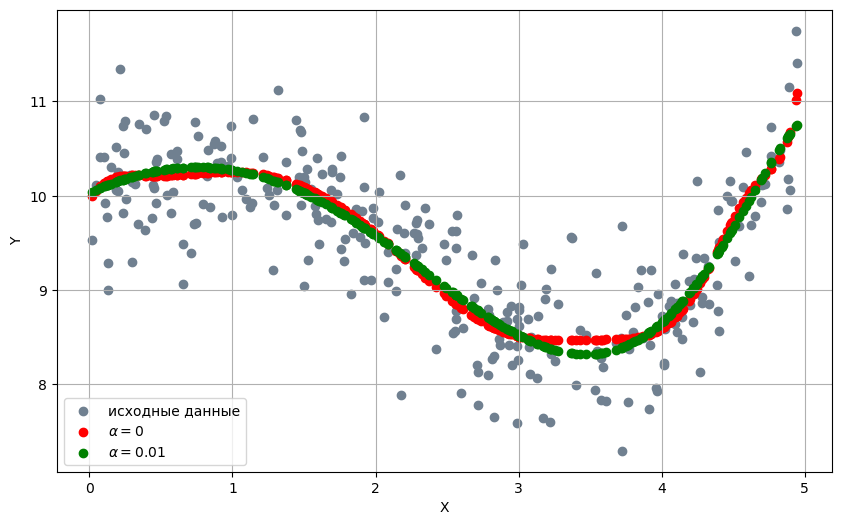

In [26]:
plt.figure("1", figsize=[10, 6])

plt.subplot(1,1,1)
plt.scatter(X[:, 0], y, color="slategrey", label="исходные данные")
plt.scatter(X[:, 0], pipelines[0].predict(X), color="red", label="$\\alpha=0$")
plt.scatter(X[:, 0], pipelines[0.01].predict(X), color="green", label="$\\alpha=0.01$")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

In [27]:
def plot_prediction_vs_true(title, y_train_true, y_train_pred, y_test_true, y_test_pred):
    plt.figure("17", figsize=[12, 8])
    plt.suptitle(f"{title}", fontsize=14)

    plt.subplot(2,2,1)
    plt.title("Train")
    plt.scatter(y_train_pred, y_train_true, color="slategrey")
    ylim = plt.gca().get_ylim()
    plt.plot(ylim, ylim, '--', color="grey")
    plt.xlim(ylim)
    plt.ylim(ylim)
    plt.xlabel("$\\hat{y}$")
    plt.ylabel("$y$")
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.title("Test")
    plt.scatter(y_test_pred, y_test_true, color="slategrey")
    ylim = plt.gca().get_ylim()
    plt.plot(ylim, ylim, '--', color="grey")
    plt.xlim(ylim)
    plt.ylim(ylim)
    plt.xlabel("$\\hat{y}$")
    plt.ylabel("$y$")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

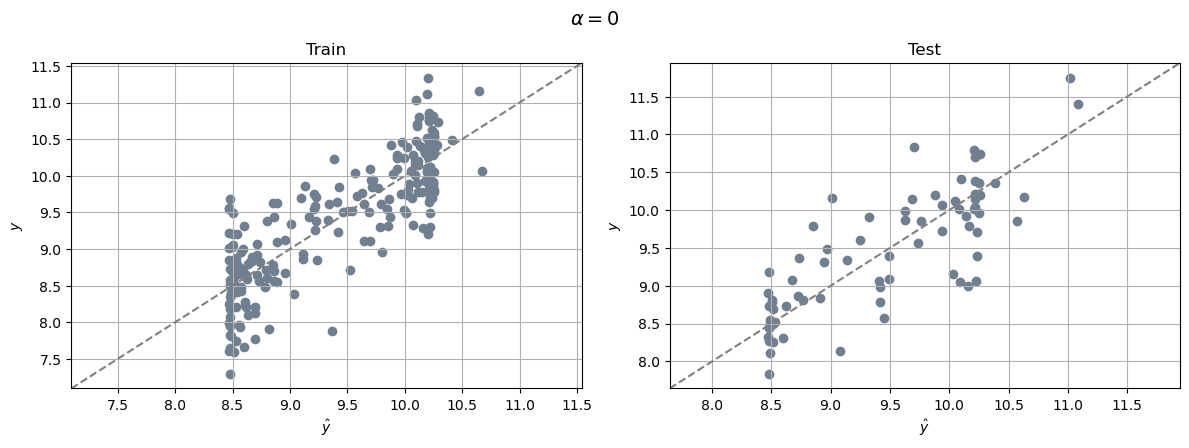

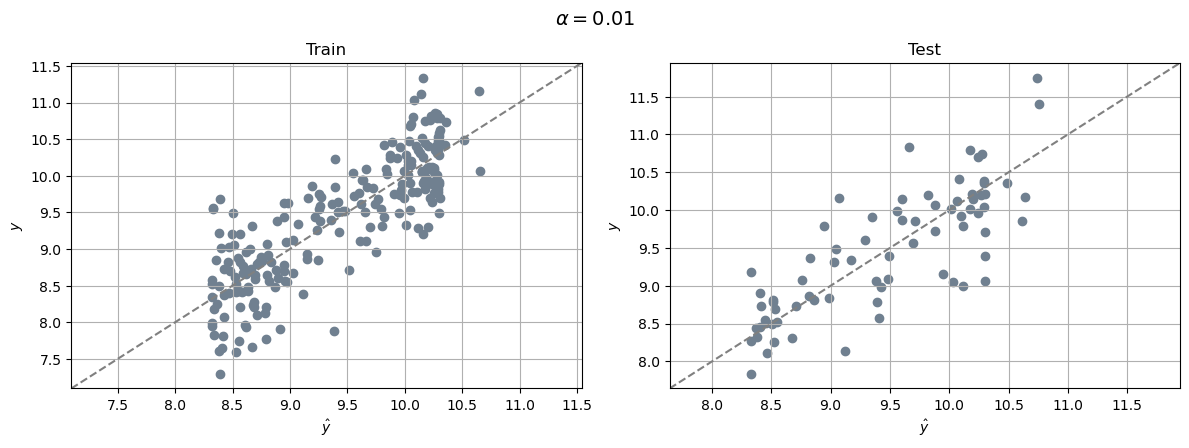

In [28]:
for alpha in ALPHAS:
    plot_prediction_vs_true(f"$\\alpha={alpha}$", y_train, pipelines[alpha].predict(X_train), y_test, pipelines[alpha].predict(X_test))

## Задача 2. Классификация и кросс-валидация (2 балла)

### Условие
> **Замечание**:
> - Используйте класс логистической регрессии из `sklearn` со следующими параметрами:
>   - `penalty='l2'`
>   - `fit_intercept=True`
>   - `max_iter=100`
>   - `C=1e5`
>   - `solver='liblinear'`
>   - `random_state=12345`
>     
> - Разбейте исходные данные на обучающее и тестовое подмножества в соотношении `70` на `30`, `random_state=0`
>
> - Для выбора гиперпараметров используйте два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
>   
> - Для кросс-валидации использовать функцию `cross_validate` из `sklearn`
>   
> - Параметры разбиения для выбора гиперпараметров используйте те, что в п.4 задачи 1

Дано множество наблюдений (см. набор данных к заданию), классификатор - логистическая регрессия. Найти степень полинома с минимальной ошибкой на проверочном подмножестве. Для лучшего случая рассчитать ошибку на тестовом подмножестве. В качестве метрики использовать долю правильных классификаций. Сделать заключение о влиянии степени полинома на качество предсказания.

Построить:
- диаграмму разброса исходных данных
- зависимость доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств (две кривые на одном графике)
- результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств с указанием границы принятия решения

### Выполнение

Проверяем наличие датасета локально, если его нет, то скачиваем

In [29]:
%%bash

source /tmp/download_dataset_file.sh

dataset_path="../data/A2_PM_dataset"
classification_file="Cl_A5_V2.csv"
link="https://raw.githubusercontent.com/MLMethods/Assignments/refs/heads/master/data/A2_Model_Selection/Cl_A5_V2.csv"

download_dataset_file "${dataset_path}" "${classification_file}" "${link}"

Let's check the availability of the dataset locally
Dataset file exist. I'm skipping the download


In [30]:
FILE_PATH = "../data/A2_PM_dataset/Cl_A5_V2.csv"

In [31]:
df = pd.read_csv(FILE_PATH, sep=",")
df

,X1,X2,Y
0,5.712051,4.420663,0
1,4.658783,6.312037,1
2,4.211528,4.934160,0
3,5.440266,5.688972,0
4,5.109973,7.006561,1
...,...,...,...
495,4.782801,5.331527,0
496,3.469108,5.801888,1
497,6.357797,4.195166,1
498,5.261725,4.757229,0


In [32]:
X = df.loc[:, df.columns != 'Y'].to_numpy()
y = df['Y'].to_numpy()

In [33]:
# Определение количества наблюдений каждого класса
labels, counts = np.unique(y, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [0 1]
Counts: [250 250]


Как видим, исходный датасет содержит два предиктора ($X_1$ и $X_2$) и одну целевую переменную ($y$).

Всего по $y$ выделено два класса, причем элементы обоих классов представлены равномерно

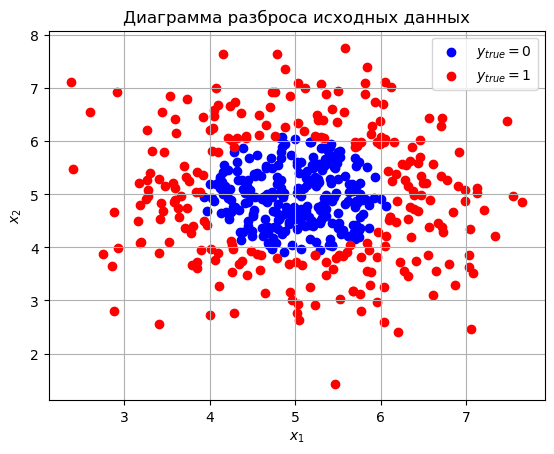

In [34]:
# График
y_one_indx = np.argwhere(y == 1).flatten()
y_zero_indx =  np.argwhere(y == 0).flatten()
plt.title("Диаграмма разброса исходных данных")
plt.scatter(X[y_zero_indx][:,0], X[y_zero_indx][:,1], color="blue", label="$y_{true} = 0$")
plt.scatter(X[y_one_indx][:,0], X[y_one_indx][:,1], color="red", label="$y_{true} = 1$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.legend()
plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (train_test_split, cross_validate)

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [36]:
%pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [37]:
from prettytable import PrettyTable

In [38]:
C                  = 1e5
MAX_ITER           = 100
TEST_SIZE          = 0.3
HOLDOUT_TRAIN_SIZE = 0.75
DEGREES            = [i for i in range(1, 17)]

In [39]:
# Разделяем данные на обучающее и тестовое множества
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=0)

# Точности при отложенной выборке и кросс-валидации
accuracies = {
    'HOLDOUT': {
        'TRAIN': np.full(len(DEGREES), 0.0),
        'VALID': np.full(len(DEGREES), 0.0)
    },
    'CROSSVAL': {
        'TRAIN': np.full(len(DEGREES), 0.0),
        'VALID': np.full(len(DEGREES), 0.0)
    }
}

pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=None)),
    ("regressor", LogisticRegression(penalty="l2",
                                     fit_intercept=True,
                                     max_iter=MAX_ITER,
                                     C=C, solver="liblinear",
                                     random_state=12345))
])

# Массив с количеством признаков на входе регрессора из пайплайна
n_features = np.full(len(DEGREES), 0)

for index, degree in enumerate(DEGREES):
    pipeline.named_steps["transformation"].degree = degree

    # Обучение с отложенной выборкой
    Xx_train, Xx_validate, yy_train, yy_validate = train_test_split(
        X_train, y_train,
        train_size=HOLDOUT_TRAIN_SIZE,
        random_state=0)
    
    pipeline.fit(Xx_train, yy_train)
    n_features[index] = pipeline.named_steps['regressor'].n_features_in_
    
    accuracies['HOLDOUT']['TRAIN'][index] = pipeline.score(Xx_train, yy_train)
    accuracies['HOLDOUT']['VALID'][index] = pipeline.score(Xx_validate, yy_validate)

    # Обучение с кросс-валидацией KFold
    scores = cross_validate(pipeline,
                            X_train, y_train, cv=kf,
                           scoring=["accuracy"],
                           return_train_score=True)
    
    accuracies['CROSSVAL']['TRAIN'][index] = scores['train_accuracy'].mean()
    accuracies['CROSSVAL']['VALID'][index] = scores['test_accuracy'].mean()

# Выведем статистику по всем степеням полинома
table = PrettyTable()
table.title = 'Точность (accuracy) в зависимости от степени полинома'
table.field_names = ['Степень полинома', 'Отложенная выборка', 'Кросс-валидация KFold', 'Количество предикторов у регрессора']
table.align = 'c'

for index, degree in enumerate(DEGREES):
    table.add_row([
        degree, accuracies['HOLDOUT']['VALID'][index],
        accuracies['CROSSVAL']['VALID'][index],
        n_features[index]
    ])

print("Количество данных для обучения (примерно):")
print("\tОтложенная выборка: ", len(X_train) * HOLDOUT_TRAIN_SIZE )
print("\tКросс-валидация KFold: ", len(X_train) * (kf.n_splits - 1) / kf.n_splits, end='\n\n')

table

Количество данных для обучения (примерно):
	Отложенная выборка:  262.5
	Кросс-валидация KFold:  262.5



Степень полинома,Отложенная выборка,Кросс-валидация KFold,Количество предикторов у регрессора
1,0.48863636363636365,0.5859130094043887,3
2,1.0,0.9942855276907001,6
3,1.0,0.9914119644723093,10
4,1.0,0.9942855276907001,15
5,1.0,0.9942855276907001,21
6,1.0,0.9856974921630094,28
7,1.0,0.9799830198537094,36
8,0.9886363636363636,0.977076802507837,45
9,0.9886363636363636,0.9799503657262278,55
10,0.9886363636363636,0.9656478578892372,66


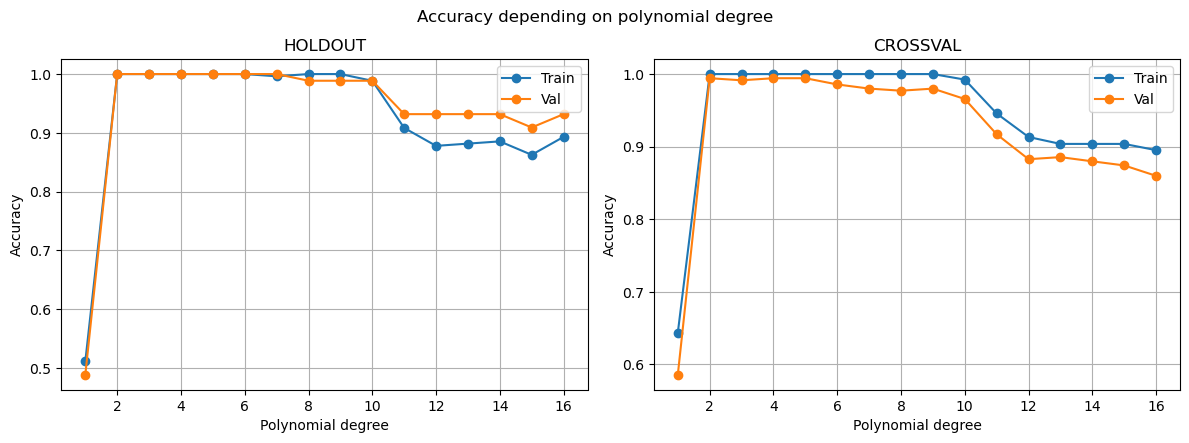

In [40]:
plt.figure("17", figsize=[12, 8])
plt.suptitle("Accuracy depending on polynomial degree")

for i, set_type in enumerate(['HOLDOUT', 'CROSSVAL']):
    plt.subplot(2,2,i+1)
    plt.title(f"{set_type}")
    plt.plot(DEGREES, [accuracies[set_type]['TRAIN'][index] for index in range(len(DEGREES))], "o-", label="Train")
    plt.plot(DEGREES, [accuracies[set_type]['VALID'][index] for index in range(len(DEGREES))], "o-", label="Val")
    plt.xlabel("Polynomial degree")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
best_degree = {}

for validation_type in ['HOLDOUT', 'CROSSVAL']:
    # Находим максимальное значение точности из всех степеней полинома
    # Если максимальное значение встречается на нескольких степенях - берем наименьшую
    max = accuracies[validation_type]['VALID'].max()
    best_degree[validation_type] = DEGREES[np.argwhere(accuracies[validation_type]['VALID'] == max ).min()]
    
    print("Степень полинома с минимальной ошибкой при ", end='')
    if validation_type == 'HOLDOUT':
        print("отложенной выборке: ", end='')
    else:
        print("кросс-валидации KFold: ", end='')
    print(best_degree[validation_type])

if best_degree['HOLDOUT'] == best_degree['CROSSVAL']:
    print("\nСтепени полинома совпали при обоих подходах")
else:
    print("\nСтепени полинома при отложенной выборке и кросс-валидации различны")


Степень полинома с минимальной ошибкой при отложенной выборке: 2
Степень полинома с минимальной ошибкой при кросс-валидации KFold: 2

Степени полинома совпали при обоих подходах


In [42]:
# Повторно обучим модель с лучшим гиперпараметром
pipeline.named_steps["transformation"].degree = best_degree['CROSSVAL']
pipeline.fit(X_train, y_train)

print("Ошибка на тестовом множестве:", 1 - pipeline.score(X_test, y_test))

Ошибка на тестовом множестве: 0.0


In [43]:
from sklearn.inspection import DecisionBoundaryDisplay

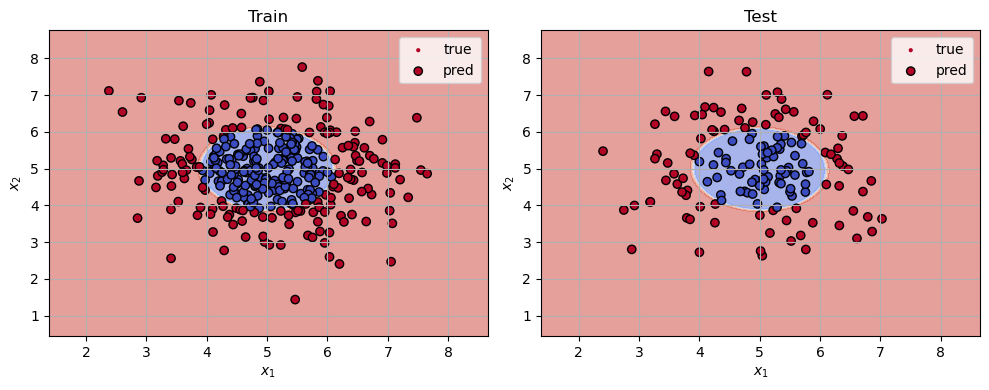

In [44]:
fig, axes = plt.subplots(1, 2, figsize=[10,4])

disp = DecisionBoundaryDisplay.from_estimator(
    pipeline, X, 
    grid_resolution=1000,
    xlabel="X1",
    ylabel="X2",
    cmap="coolwarm",
    response_method="predict_proba",
    alpha=0.5,
    ax=axes[0]
)

y_train__pred = pipeline.predict(X_train)
y_test__pred = pipeline.predict(X_test)

axes[0].set_title("Train")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
sc_train = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train__pred, cmap="coolwarm", s=4, label="true")
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train__pred, cmap="coolwarm", edgecolor="k", label="pred")
axes[0].legend()
# fig.colorbar(sc_train, cmap="coolwarm")
axes[0].grid(True)

disp.plot(ax=axes[1], alpha=0.5, cmap="coolwarm")
axes[1].set_title("Test")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
sc_test = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", s=4, label="true")
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test__pred, cmap="coolwarm", edgecolor="k", label="pred")
axes[1].legend()
# fig.colorbar(sc_test, cmap="coolwarm")
axes[1].grid(True)

fig.tight_layout()

plt.show()

#### Вывод

Для имеющегося набора данных и выбранной модели (логистической регрессии) полином 1-ой степени дает плохое качество предсказания (точность около `0.59` при кросс-валидации KFold). Это связано с нелинейной зависимостью между предикторами $X_1$, $X_2$ и выходной переменной $y$.

Повышение степени полинома (до $2 - 6$) увеличивает точность предсказания практически до `1.0`, однако с большим повышением степени полинома качество предсказания падает (падение особенно заметно при переходе от 10 степени к 11 и выше).

Возможные причины ухудшения качества предсказания:
- Излишнаяя гибкость модели, которая приводит к ее переобучению
- Большое количество параметров (предикторов) при небольшом объеме данных для обучения: выше было выведено количество предикторов у модели логистической регрессии в пайплайне, а также выведен объем данных для обучения модели. Видно, что при высоких степенях полинома количество признаков приближается к числу наблюдений (например, для полинома степени 16 это `153` параметра при `262` наблюдениях), что делает модель более зависимой от входных данных и ухудшает ее обучающую способность

## Задача 3. Классификация текстовых документов (4 балла)

## Условие

> Для **3 варианта** набор рецензий на фильмы (reviews), файл `data/reviews.tsv`

> **Замечание**:
> - Для всех объектов/методов/моделей `random_state = 123`
> - Для выбора гиперпараметров можно использовать стандартные утилиты `sklearn`

1. Загрузите исходные данные
   
2. Разбейте исходные данные на обучающее (train, 80%) и тестовое подмножества (test, 20%)

3. Используя стратифицированную кросс-валидацию k-folds ($k=4$) для обучающего множество с метрикой `Balanced-Accuracy`, найдите лучшие гиперпараметры для следующих классификаторов:
   - K-ближайших соседей: количество соседей ($n$) из диапазона `np.arange(1, 150, 20)`;
     
   - Логистическая регрессия: параметр регуляризации ($C$) из диапазона `np.logspace(-2, 10, 8, base=10)`;

   - Наивный Байес: сглаживающий параметр модели Бернулли ($\alpha$) из диапазона `np.logspace(-4, 1, 8, base=10)`;

   - Наивный Байес: сглаживающий параметр полиномиальной модели ($\alpha$) из диапазона `np.logspace(-4, 1, 8, base=10)`

4. Отобразите кривые (параметры модели)-(Balanced-Accuracy) при обучении и проверке для каждой классификатора (две кривые на одном графике для каждого классификатора)

5. Если необходимо, выбранные модели обучите на всём обучающем подмножестве (train) и протестируйте на тестовом (test) по Balanced-Accuracy, R, P, F1. Определите время обучения и предсказания.

6. Выполните пункты 3-5 для n-gram=1, n-gram=2 и n-gram=(1,2)

7. Выведите в виде таблицы итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, метрики (Balanced-Accuracy, R, P, F1))

8. Сделайте выводы по полученным результатам (преимущества и недостатки методов)


### Выполнение

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, StratifiedKFold)

Проверяем наличие датасета локально, если его нет, то скачиваем

In [46]:
%%bash

source /tmp/download_dataset_file.sh

dataset_path="../data/A2_PM_dataset"
classification_file="reviews.tsv"
link="https://raw.githubusercontent.com/MLMethods/Assignments/7d189c5bafec625e0d2a1779d482f7ed7a492c21/data/A3_Text_Classification/reviews.tsv"

download_dataset_file "${dataset_path}" "${classification_file}" "${link}"

Let's check the availability of the dataset locally
Dataset file exist. I'm skipping the download


In [47]:
FILE_PATH = "../data/A2_PM_dataset/reviews.tsv"

In [48]:
df = pd.read_csv(FILE_PATH, sep='\t', header=None, names=['grade', 'review'])
df

,grade,review
0,0,unless bob crane is someone of particular inte...
1,1,"finds a way to tell a simple story , perhaps t..."
2,0,"ill-considered , unholy hokum ."
3,0,"nijinsky says , 'i know how to suffer' and if ..."
4,1,the auteur's ear for the way fears and slights...
...,...,...
10657,0,"it's mildly sentimental , unabashedly consumer..."
10658,0,so verbally flatfooted and so emotionally pred...
10659,0,alternative medicine obviously has its merits ...
10660,0,a by-the-numbers patient/doctor pic that cover...


In [49]:
X = df.loc[:, df.columns == 'review']
y = df['grade'].to_numpy()

In [50]:
# Определение количества наблюдений каждого класса
labels, counts = np.unique(y, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [0 1]
Counts: [5331 5331]


Как видим, датасет содержит два класса наблюдений `0` и `1`, представленные в одинаковой пропорции

In [51]:
RANDOM_STATE = 123
SPLITS       = 4
NGRAMS       = [(1,1), (2,2), (1,2)]

In [52]:
# Разделяем данные на обучающее и тестовое множества
X_train, X_test, y_train, y_test = train_test_split(X['review'], y, train_size=0.8, random_state=RANDOM_STATE)

skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [53]:
def get_best_model_params_and_metrics(model,
                                      X_train, y_train,
                                      cv, params=None, scoring='balanced_accuracy'):
    scores = {}
    
    model = clone(model)

    model_grid = GridSearchCV(model, params, cv=cv, return_train_score=True, scoring=scoring, n_jobs=-1)
    model_grid.fit(X_train, y_train)
    
    results = model_grid.cv_results_
    for validation_type in ['train', 'test']:
        # GridSearchCV возвращает для каждого сплита массив метрик для каждого значения параметра
        # Соберем все сплиты в двумерный numpy массив: по строкам - сплиты, по столбцам - уникальное значение параметра и
        # выдадим среднее по столбцам (каждому параметру)
        splits_metrics =  np.array(
            [results[f'split{split_index}_{validation_type}_score'] for split_index in range(cv.n_splits)]
        )

        if validation_type == 'train':
            scores['TRAIN'] = np.mean(splits_metrics, axis=0)
        elif validation_type == 'test':
            scores['VALID'] = np.mean(splits_metrics, axis=0)

    return model_grid.best_params_, scores

In [54]:
def plot_train_val_metric(X, y_train, y_valid, logscale=False, title=None, ylabel="Balanced-Accuracy", xlabel=None):
    plt.figure("17", figsize=[6, 4])

    if title is not None:
        plt.suptitle(title)

    plt.subplot(1,1,1)
    plt.plot(X, y_train, "o-", label="Train")
    plt.plot(X, y_valid, "o-", label="Val")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel("Hyperparameter degree")
    
    plt.ylabel(ylabel)

    if logscale:
        plt.xscale("log")

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [55]:
from sklearn.metrics import (
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

In [56]:
# Собираем все результаты как строки будущей итоговой таблицы
# Название модели - N_gram - значение параметра модели - время обучения - время предсказания - Balanced-Accuracy - R - P - F1
table_rows = []

**K-ближайших соседей**

In [57]:
def do_supervise_and_plot_metrics(pipe,
                                  X_train, y_train,
                                  X_test, y_test, cv,
                                  params, param_name,
                                  model_name, x_label,
                                  use_log_scale=False):

    for index, ngram in enumerate(NGRAMS):
        paramgrid_name = [key for key in params][0]
        
        pipe.named_steps['vectorizer'].ngram_range = ngram
        
        best_params, scores = get_best_model_params_and_metrics(
            pipe,
            X_train,
            y_train,
            # cv=skf,
            cv=cv,
            params=params
        )
    
        best_param_pos = np.argwhere(
            params[paramgrid_name] == best_params[paramgrid_name]
        ).flatten()[0]
    
        best_score = {
            'TRAIN': scores['TRAIN'][best_param_pos],
            'VALID': scores['VALID'][best_param_pos]
        }
    
        # knn_best_params.append(best_params)
        # knn_best_scores.append(best_score)
    
        # Обучим на всем обучающем множестве с лучшим гиперпараметром
        setattr(pipe.named_steps['classifier'], param_name, best_params[paramgrid_name])
        # pipe.named_steps['classifier'].n_neighbors = best_params[param_name]
        fit_time = %timeit -o pipe.fit(X_train, y_train)
        predict_time = %timeit -o pipe.predict(X_test)
    
        y_test_predicted = pipe.predict(X_test)
        balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)
        recall = recall_score(y_test, y_test_predicted)
        precision = precision_score(y_test, y_test_predicted)
        f1 = f1_score(y_test, y_test_predicted)
    
        print(f"ngram_range: {ngram}")
        print("Лучший параметр:")
        print(f"\t{best_params[paramgrid_name]}")
        print("Метрики при лучшем параметре:")
        print(f"\tTRAIN BALANCED-ACCURACY: {best_score['TRAIN']}")
        print(f"\tVALID BALANCED-ACCURACY: {best_score['VALID']}")
    
        print("\nВремя обучения:\n\t", fit_time.average)
        print("\nВремя предсказания:\n\t", predict_time.average)
    
        print("\nМетрики на подмножестве test:")
        print("\tBalanced-Accuracy: ", balanced_accuracy)
        print("\tRecall: ", recall)
        print("\tPrecision: ", precision)
        print("\tF1: ", f1)
    
        table_rows.append([
            model_name,
            str(ngram),
            round(best_params[paramgrid_name],5),
            round(fit_time.average,5), round(predict_time.average,5),
            round(balanced_accuracy,5), round(recall,5), round(precision,5), round(f1,5)
        ])
    
        plot_train_val_metric(
            params[paramgrid_name],
            scores['TRAIN'], scores['VALID'],
            title=f"{model_name} (ngram_range = {ngram})",
            xlabel=x_label,
            logscale=use_log_scale
        )

57.1 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
382 ms ± 42.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
ngram_range: (1, 1)
Лучший параметр:
	41
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.7566369407747412
	VALID BALANCED-ACCURACY: 0.7276448983845297

Время обучения:
	 0.057133456799991635

Время предсказания:
	 0.3823219338581631

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7449543704172601
	Recall:  0.7490636704119851
	Precision:  0.7434944237918215
	F1:  0.7462686567164178


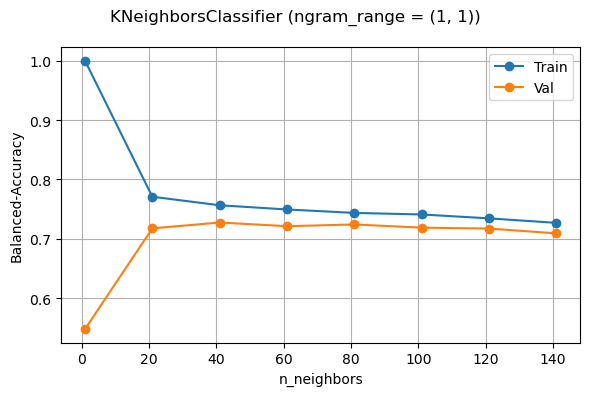

111 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
135 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (2, 2)
Лучший параметр:
	141
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.6151080288019026
	VALID BALANCED-ACCURACY: 0.5418401070279654

Время обучения:
	 0.11075001482833093

Время предсказания:
	 0.13514299900011142

Метрики на подмножестве test:
	Balanced-Accuracy:  0.5032705596877143
	Recall:  0.011235955056179775
	Precision:  0.7058823529411765
	F1:  0.022119815668202765


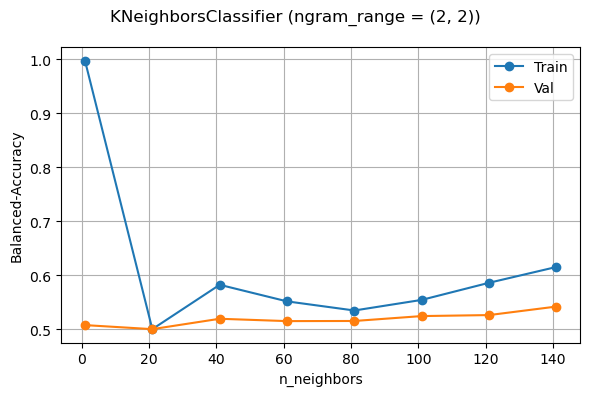

140 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
662 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
ngram_range: (1, 2)
Лучший параметр:
	41
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.7526478123865885
	VALID BALANCED-ACCURACY: 0.7248238221038248

Время обучения:
	 0.14012910395717232

Время предсказания:
	 0.6622010837142754

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7402674473809148
	Recall:  0.7434456928838952
	Precision:  0.7392923649906891
	F1:  0.7413632119514473


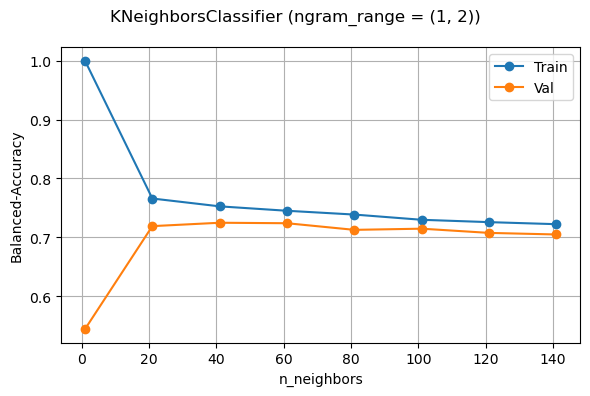

In [58]:
knn_params = {
    "classifier__n_neighbors": np.arange(1, 150, 20)
}

knn_pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase=True, stop_words="english",
                                       use_idf=True, ngram_range=(1,1),
                                       smooth_idf=False)),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

do_supervise_and_plot_metrics(knn_pipe,
                              X_train, y_train,
                              X_test, y_test,
                              cv=skf,
                              params=knn_params,
                              param_name="n_neighbors",
                              model_name="KNeighborsClassifier",
                              x_label="n_neighbors",
                              use_log_scale=False)

**Логистическая регрессия**

144 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.9 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (1, 1)
Лучший параметр:
	0.517947467923121
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.8952575857129368
	VALID BALANCED-ACCURACY: 0.7412354961008398

Время обучения:
	 0.1441484862143365

Время предсказания:
	 0.012942278685659404

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7698000738513477
	Recall:  0.7752808988764045
	Precision:  0.7673772011121409
	F1:  0.7713088029809037


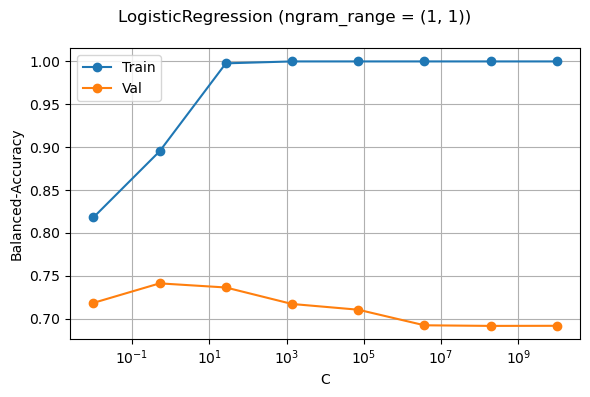

200 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.4 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (2, 2)
Лучший параметр:
	0.517947467923121
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9965618282964669
	VALID BALANCED-ACCURACY: 0.5995452365250359

Время обучения:
	 0.19952625371432595

Время предсказания:
	 0.01737871762857789

Метрики на подмножестве test:
	Balanced-Accuracy:  0.6040723743208314
	Recall:  0.7752808988764045
	Precision:  0.5782122905027933
	F1:  0.6624


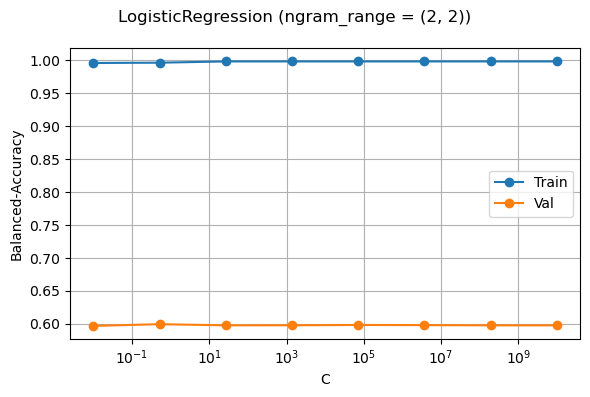

300 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.6 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (1, 2)
Лучший параметр:
	26.826957952797247
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9998827880783057
	VALID BALANCED-ACCURACY: 0.7476895689604238

Время обучения:
	 0.3002894237153149

Время предсказания:
	 0.020600051471618436

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7674341931740254
	Recall:  0.7883895131086143
	Precision:  0.7571942446043165
	F1:  0.7724770642201835


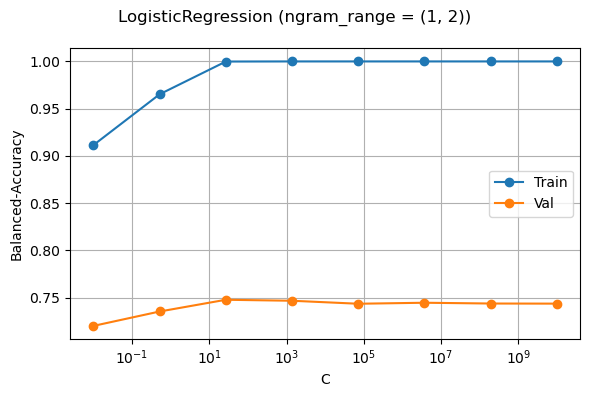

In [59]:
logreg_params = {
    "classifier__C": np.logspace(-2, 10, 8, base=10)
}

logreg_pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase=True, stop_words="english",
                                       use_idf=True, ngram_range=(1,1),
                                       smooth_idf=False)),
    ("classifier", LogisticRegression(penalty="l2",
                                      fit_intercept=True,
                                      max_iter=MAX_ITER,
                                      C=C, solver="liblinear",
                                      random_state=RANDOM_STATE))
])

do_supervise_and_plot_metrics(logreg_pipe,
                              X_train, y_train,
                              X_test, y_test,
                              cv=skf,
                              params=logreg_params,
                              param_name="C",
                              model_name="LogisticRegression",
                              x_label="C",
                              use_log_scale=True)

**Наивный Байес (модель Бернулли)**

57.5 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.4 ms ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ngram_range: (1, 1)
Лучший параметр:
	1.9306977288832496
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9267163725827456
	VALID BALANCED-ACCURACY: 0.7625712464889405

Время обучения:
	 0.05748884208566908

Время предсказания:
	 0.012362757547141102

Метрики на подмножестве test:
	Balanced-Accuracy:  0.774516009917181
	Recall:  0.7602996254681648
	Precision:  0.7830279652844745
	F1:  0.7714964370546318


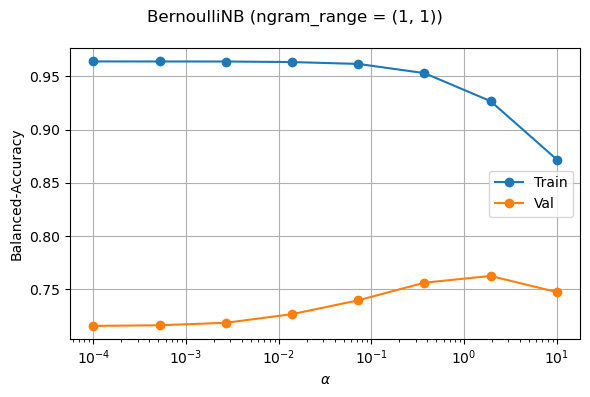

111 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.9 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ngram_range: (2, 2)
Лучший параметр:
	0.3727593720314942
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9983579210536457
	VALID BALANCED-ACCURACY: 0.5989362053391756

Время обучения:
	 0.1110854065285821

Время предсказания:
	 0.01689848379285

Метрики на подмножестве test:
	Balanced-Accuracy:  0.6162987287017988
	Recall:  0.42790262172284643
	Precision:  0.687218045112782
	F1:  0.527409117137911


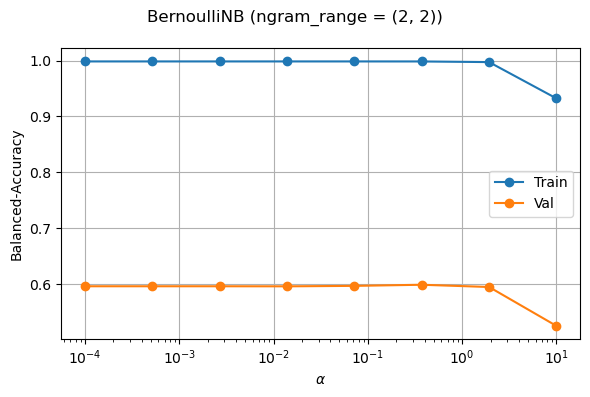

142 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.4 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (1, 2)
Лучший параметр:
	1.9306977288832496
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9899536926559603
	VALID BALANCED-ACCURACY: 0.7598630313755488

Время обучения:
	 0.14177000775723303

Время предсказания:
	 0.022365654671531437

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7792635965606372
	Recall:  0.7228464419475655
	Precision:  0.8152059134107709
	F1:  0.7662531017369727


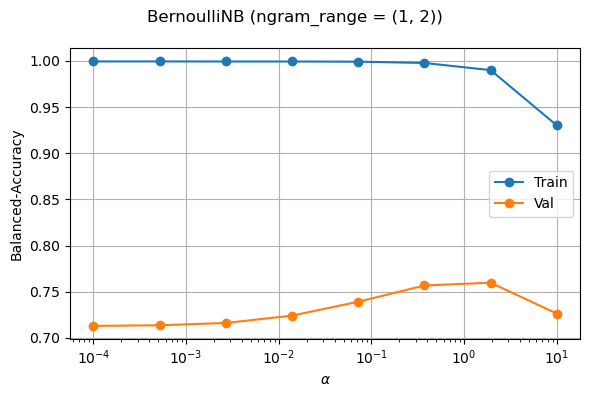

In [60]:
bernoulli_params = {
    "classifier__alpha": np.logspace(-4, 1, 8, base=10)
}

bernoulli_pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase=True, stop_words="english",
                                       use_idf=True, ngram_range=(1,1),
                                       smooth_idf=False)),
    ("classifier", BernoulliNB())
])

do_supervise_and_plot_metrics(bernoulli_pipe,
                              X_train, y_train,
                              X_test, y_test,
                              cv=skf,
                              params=bernoulli_params,
                              param_name="alpha",
                              model_name="BernoulliNB",
                              x_label="$\\alpha$",
                              use_log_scale=True)

**Наивный Байес (полиномиальная модель)**

58.6 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.1 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ngram_range: (1, 1)
Лучший параметр:
	1.9306977288832496
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9305131939511088
	VALID BALANCED-ACCURACY: 0.7648116300074125

Время обучения:
	 0.05863225568568201

Время предсказания:
	 0.013084572087152213

Метрики на подмножестве test:
	Balanced-Accuracy:  0.772113203565965
	Recall:  0.799625468164794
	Precision:  0.7584369449378331
	F1:  0.7784867821330902


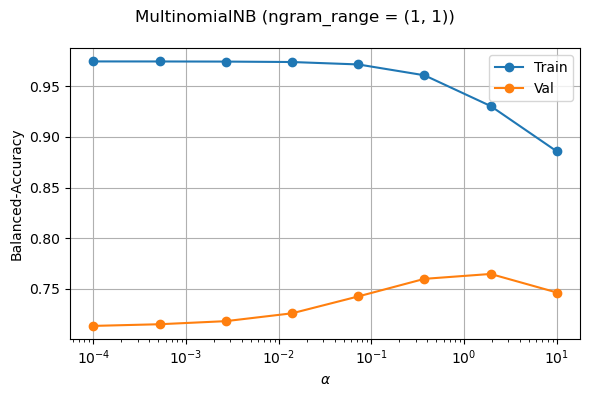

113 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.6 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ngram_range: (2, 2)
Лучший параметр:
	0.3727593720314942
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.9984752185200205
	VALID BALANCED-ACCURACY: 0.6009399753051632

Время обучения:
	 0.11345009021419432

Время предсказания:
	 0.01656993707141997

Метрики на подмножестве test:
	Balanced-Accuracy:  0.6204818800443108
	Recall:  0.45786516853932585
	Precision:  0.6791666666666667
	F1:  0.5469798657718121


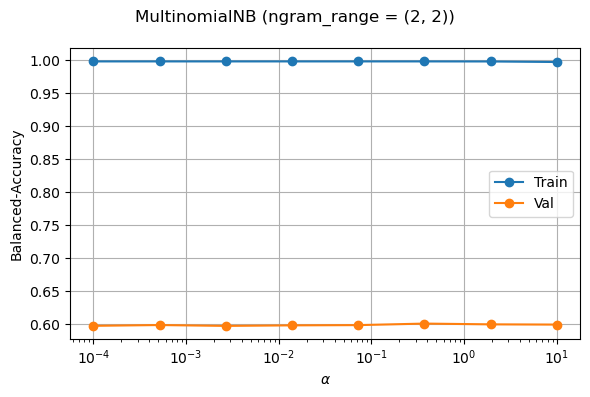

148 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.2 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
ngram_range: (1, 2)
Лучший параметр:
	1.9306977288832496
Метрики при лучшем параметре:
	TRAIN BALANCED-ACCURACY: 0.99257405680184
	VALID BALANCED-ACCURACY: 0.7609431215354535

Время обучения:
	 0.14783382325726313

Время предсказания:
	 0.0212284904140688

Метрики на подмножестве test:
	Balanced-Accuracy:  0.7744566650841378
	Recall:  0.802434456928839
	Precision:  0.7604259094942325
	F1:  0.780865603644647


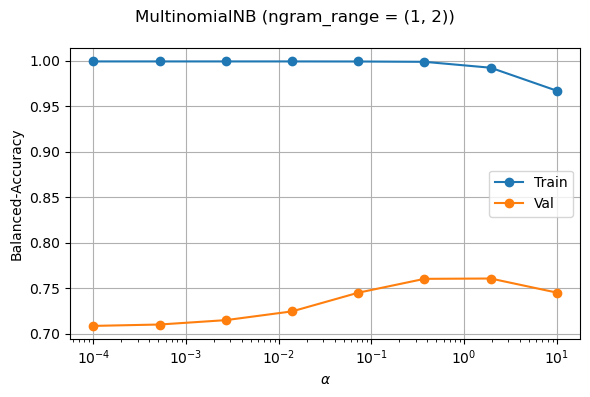

In [61]:
polynom_params = {
    "classifier__alpha": np.logspace(-4, 1, 8, base=10)
}

polynom_pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase=True, stop_words="english",
                                       use_idf=True, ngram_range=(1,1),
                                       smooth_idf=False)),
    ("classifier", MultinomialNB())
])

do_supervise_and_plot_metrics(polynom_pipe,
                              X_train, y_train,
                              X_test, y_test,
                              cv=skf,
                              params=polynom_params,
                              param_name="alpha",
                              model_name="MultinomialNB",
                              x_label="$\\alpha$",
                              use_log_scale=True)

Итоговая таблица

In [62]:
table = PrettyTable()

table.field_names = [
    'Название модели',
    'N_gram',
    'Значение параметра модели',
    'Время обучения',
    'Время предсказания',
    'Balanced-Accuracy',
    'R',
    'P',
    'F1'
]
table.align = 'c'
table.add_rows(table_rows)

table

Название модели,N_gram,Значение параметра модели,Время обучения,Время предсказания,Balanced-Accuracy,R,P,F1
KNeighborsClassifier,"(1, 1)",41,0.05713,0.38232,0.74495,0.74906,0.74349,0.74627
KNeighborsClassifier,"(2, 2)",141,0.11075,0.13514,0.50327,0.01124,0.70588,0.02212
KNeighborsClassifier,"(1, 2)",41,0.14013,0.6622,0.74027,0.74345,0.73929,0.74136
LogisticRegression,"(1, 1)",0.51795,0.14415,0.01294,0.7698,0.77528,0.76738,0.77131
LogisticRegression,"(2, 2)",0.51795,0.19953,0.01738,0.60407,0.77528,0.57821,0.6624
LogisticRegression,"(1, 2)",26.82696,0.30029,0.0206,0.76743,0.78839,0.75719,0.77248
BernoulliNB,"(1, 1)",1.9307,0.05749,0.01236,0.77452,0.7603,0.78303,0.7715
BernoulliNB,"(2, 2)",0.37276,0.11109,0.0169,0.6163,0.4279,0.68722,0.52741
BernoulliNB,"(1, 2)",1.9307,0.14177,0.02237,0.77926,0.72285,0.81521,0.76625
MultinomialNB,"(1, 1)",1.9307,0.05863,0.01308,0.77211,0.79963,0.75844,0.77849
